<a href="https://colab.research.google.com/github/Trongnhat191/Image-Retrieval/blob/main/Image_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.31.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Project_Image_Retrieval

/content/drive/MyDrive/Colab Notebooks/Project_Image_Retrieval


In [ ]:
# !unzip image_retrieval_dataset.zip

In [ ]:
dataset_dir = 'images_mr'

In [ ]:
image_filenames = os.listdir(dataset_dir)

In [ ]:
#Read image
src_images = []

for filename in image_filenames:
    filepath = os.path.join(dataset_dir, filename)

    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

In [ ]:
#resize to 64x64x3
def image_resize(images, target_size= (64,64)):
    resized_image = cv2.resize(
        images,
        target_size
    )
    return resized_image

In [ ]:
#normalize use Z-score normalization
#transform data so that it has a mean of 0 and a std of 1: X(nor) = (X-mean)/std
def calculate_mean_std(images):
    mean = np.mean(images, axis = (0,1,2))
    std = np.std(images, axis = (0,1,2))
    return mean, std

def image_std_normalize(images, mean, std):
    normalized_image = (images - mean) / std
    return normalized_image


In [ ]:
#flatten images
def image_flatten(images, is_batch =False):
    if is_batch:#input is a list of images
        return images.reshape(images.shape[0], -1)
    else:# input is just 1 image
        return images.reshape(-1)

In [ ]:
#combines 3 functions above
def preprocess_batches(images):
    resized_images = [image_resize(image) for image in src_images]
    images_arr = np.array(resized_images)
    mean, std = calculate_mean_std(images_arr)
    normalized_images = image_std_normalize(
        images_arr,
        mean, std
    )
    flattened_images = image_flatten(
        normalized_images,
        is_batch = True
    )
    return flattened_images, mean, std


In [ ]:
def preprocess_query(image):
    resized_image = image_resize(image)
    normalized_image = image_std_normalize(
        resized_image,
        mean, std
    )
    flattened_image = image_flatten(normalized_image)
    return flattened_image

In [ ]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)

    mae = np.mean(abs_diff, axis = 1)
    return mae

In [ ]:
def mean_squared_error(query_vector, src_vectors):
    mse = np.mean((src_vectors - query_vector)**2, axis = 1)
    return mse

In [ ]:
def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector/ query_norm
    src_norms = np.linalg.norm(src_vectors, axis = 1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]

    cos_sim = np.dot(
        normalized_src,
        normalized_query)
    return cos_sim


In [ ]:
def correlation_coefficient(query_vector, src_vectors):
    corr_coef = np.corrcoef(
        query_vector,
        src_vectors
    )[:-1, -1]

    return corr_coef

In [ ]:
#using cosine_similarity
def ranking(
    preprocessed_query_image,
    preprocessed_src_images,
    top_k = 10
):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[::-1][:top_k]#[::-1] de sap xep giam dan
    scores = scores[ranked_list]
    return ranked_list, scores

Query Image


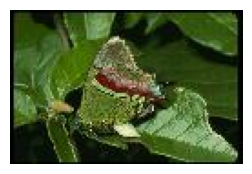

Top 10 results


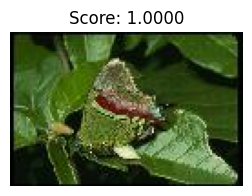

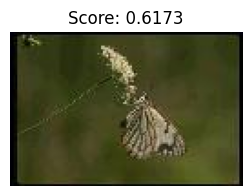

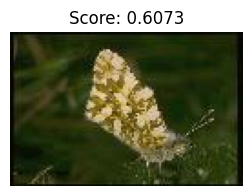

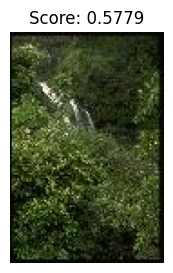

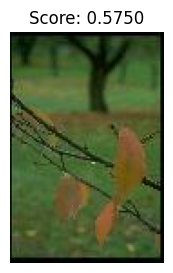

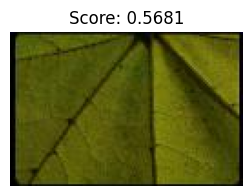

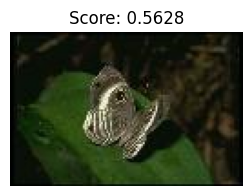

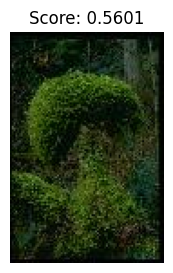

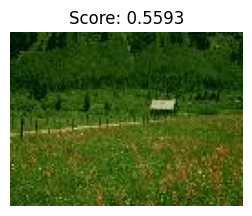

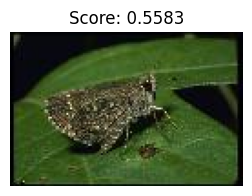

In [ ]:
query_image_paths = ['images_mr/1.jpg']
preprocessed_src_images, mean, std = preprocess_batches(src_images)
top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path,1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocess_query(query_image)

    ranked_list, scores = ranking(
        preprocessed_query_image,
        preprocessed_src_images,
        top_k
    )

    print('Query Image')
    plt.figure(figsize = (3,3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    print(f"Top {top_k} results")
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize = (3,3))
        plt.imshow(src_images[src_image_idx])
        plt.axis('off')
        plt.title(f"Score: {similarity_score:.4f}")
        plt.show()

In [ ]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
src_images = []

for filename in image_filenames:
    filepath = os.path.join(dataset_dir, filename)

    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
def preprocessing(images):
    inputs = processor(
        images,
        return_tensors = 'pt'
    ).to(device)

    with torch.no_grad():
        output = model(
            **inputs,
            output_hidden_states = True
        ).hidden_states[-1][:, 0, :].detach().cpu().numpy()

    return output

In [ ]:
preprocessed_src_images = preprocessing(src_images)

Query Image


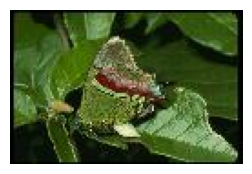

Top 10 results


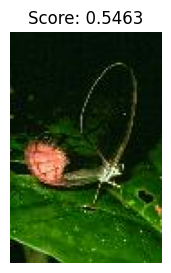

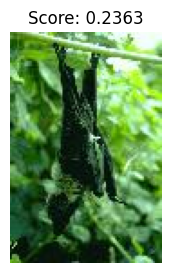

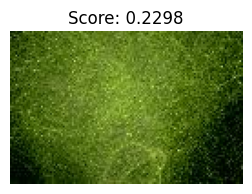

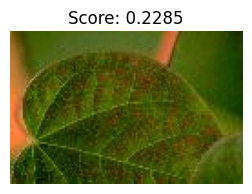

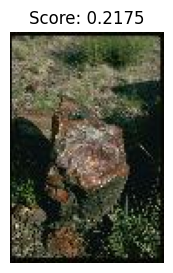

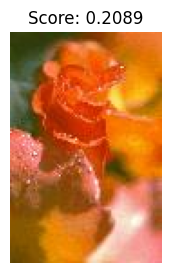

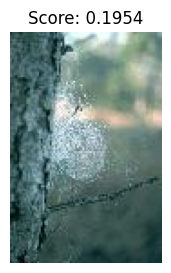

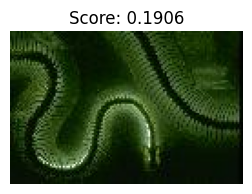

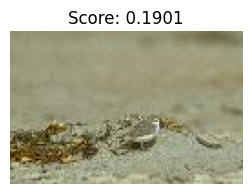

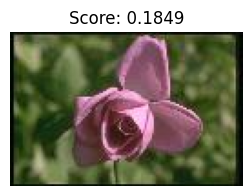

In [ ]:
query_image_paths = ['images_mr/1.jpg']
top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path,1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocessing(query_image).squeeze(0)

    ranked_list, scores = ranking(
        preprocessed_query_image,
        preprocessed_src_images,
        top_k
    )

    print('Query Image')
    plt.figure(figsize = (3,3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    print(f"Top {top_k} results")
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize = (3,3))
        plt.imshow(src_images[src_image_idx])
        plt.axis('off')
        plt.title(f"Score: {similarity_score:.4f}")
        plt.show()